<h2> Workflow</h2>
* Reading .dat file.
* Extracting necessary information.
* Ploting magnetization vs applied field for a sample before and after irradiation.
* Rearranging data for two cycles of magnetization.
* Fitting the data and doing necessary Extrapolation at the highest magnetic field applied.



<h2> The raw data </h2>
* First 30 rows are information about parameters(which is unnecessary for further analysis.)
* It has about 30 fields and 100 rows of information to be extracted.

<h2> It looks like this </h2>
<img src="rawdata.png">

 <strong>Importing necessary libraries</strong>

In [51]:
import pandas as pd 
import scipy
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

<strong> Creating a function to plot Magnetization vs Applied field for specific temperature.</strong>

In [103]:
def Mag_Plot(temp):
    pristine='SP-M4-239-3-0104-#4/Pristine/MH'+str(temp)+'K.dc.dat'
    irradiated='SP-M4-239-3-0104-#4/Irradiated/MH'+str(temp)+'K.dc.dat'
    Pristine=pd.read_table(pristine,skiprows=30,sep=',',usecols=[2,4])
    Irradiated=pd.read_table(irradiated,skiprows=30,sep=',',usecols=[2,4])
    fig=plt.figure(1,(8,6))
    fig.suptitle('For '+str(temp)+ 'K Temperature')
    ax=fig.add_subplot(111)
    Pristine.plot.scatter('Field (Oe)', 'Long Moment (emu)',color='b', label='Pristine',ax=ax)
    Irradiated.plot.scatter('Field (Oe)','Long Moment (emu)',color='r',label='Irradiated', ax=ax)


<strong> Executing the plot for 5 K temperature.</strong>

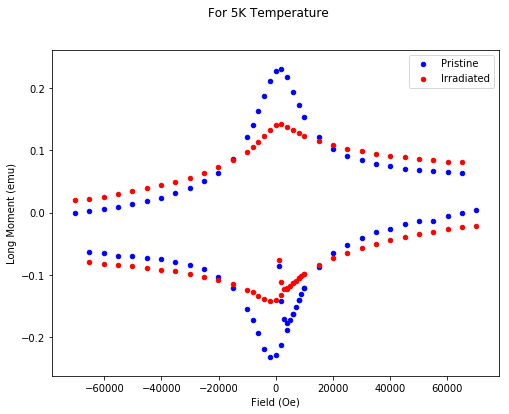

In [104]:
magnetization_plot=Mag_Plot(5)

<strong> As you can see in the plot above applied field (horizontal axis) is from around -70k oe to 70k oe. But on left 
side, it does not have a magnetization data for lower cycle for -70k oe also on right side it does not have magnetization
data for upper cycle for 70k oe. For these misssing data we need to fit the data and carry out extrapolation.</strong>

<strong>We import interpolate.rbf method from scipy library for interpolation.</strong>

In [71]:
from scipy.interpolate.rbf import Rbf

In [72]:
def Interpolation(datapath):
    data=pd.read_table(datapath,sep=',', skiprows=30,usecols=[2,4])
#     separating two cycles of magnetization B cycle and D cycle
    A=data[10:22]
    B=data[22:56]
    C=data[56:]
    D = C.append(A)
    B=B[::-1]
#     converting units of applied magnetic field to kOe and changing datatype to numpy array.
    H1=np.array(B['Field (Oe)'])*1/1000
    M1=np.array(B['Long Moment (emu)'])
    H2=np.array(D['Field (Oe)'])*1/1000
    M2=np.array(D['Long Moment (emu)'])
#     fitting the data and making prediction 
    rbf_adj = Rbf(H1, M1, function='linear')
    M_predict = rbf_adj(H2)
    
    return M2,M1,M_predict,H2,H1

<strong> Lets see how well we are able to fit the data. We can change the rbf funtion from 'linear' to some other
type to see if other function fits better. I have fund linear function giving better fitting.</strong>

In [80]:
M2,M1,M_predict,H2,H1=Interpolation('SP-M4-239-3-0104-#4/Pristine/MH5K.dc.dat')
M2_I,M1_I,M_predict_I,H2_I,H1_I=Interpolation('SP-M4-239-3-0104-#4/Irradiated/MH5K.dc.dat')

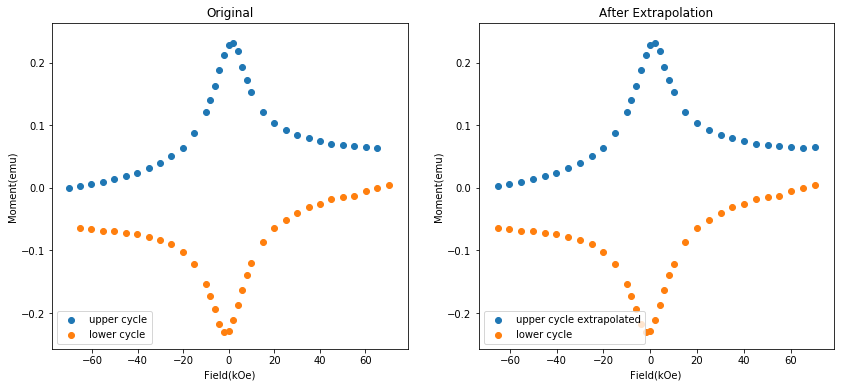

In [81]:
fig=plt.figure(1,(14,6))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
ax1.scatter(H1,M1,label='upper cycle')
ax1.scatter(H2,M2,label='lower cycle')
ax2.scatter(H2,M_predict,label='upper cycle extrapolated')
ax2.scatter(H2,M2,label='lower cycle')
ax1.set_title("Original")
ax1.set_xlabel("Field(kOe)")
ax1.set_ylabel("Moment(emu)")
ax2.set_title("After Extrapolation")
ax2.set_xlabel("Field(kOe)")
ax2.set_ylabel("Moment(emu)")
ax1.legend(loc=3)
ax2.legend(loc=3)

<strong> Extrapolation looks good. Now lets move on to find Critical current density.</strong>

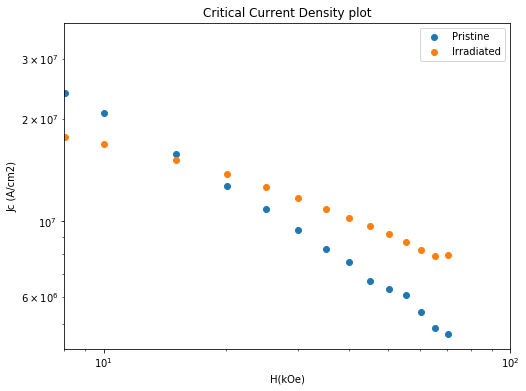

In [105]:
# Radius of the sample
R=0.0748
# Thickness of the sample
t=1.5e-4
#value of pi
pi=3.14
# Critical current densities
Jc_before=(M_predict-M2)*15/(pi*R**3*t)
Jc_after=(M_predict_I-M2_I)*15/(pi*R**3*t)

plt.figure(1,(8,6))
plt.scatter(H2,Jc_before,label='Pristine')
plt.scatter(H2_I,Jc_after,label='Irradiated')
plt.title("Critical Current Density plot")
plt.xlabel("H(kOe)")
plt.ylabel("Jc (A/cm2)")
plt.yscale('log')
plt.xscale('log')
plt.xlim(8, 100)
plt.legend( loc=1)


<h2> The end </h2>